In [163]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from sklearn.kernel_ridge import KernelRidge
import pickle

In [7]:
database = "data.sqlite"

conn = sqlite3.connect(database)

train_df = pd.read_sql("select * from new_table_name", con=conn)
train_df.head()

,Unnamed: 0,year,make,model,final_price,mileage,engine,zipcode,engine string
0,1,1997,Chevrolet,Chevrolet Suburban,"$17,000",67000,5700.0,60069,5.7L Vortec V8
1,2,1990,Porsche,Porsche 964 911,"$225,000",1000,3800.0,84790,3.8-Liter Flat-Six
2,3,2003,Toyota,Toyota Pickup,"$24,750",116000,3400.0,90027,3.4-Liter DOHC V6
3,5,1992,Volkswagen,Volkswagen Golf/Rabbit Cabriolet,"$10,750",100000,1800.0,98208,1.8-Liter Inline-Four
4,6,2008,Toyota,Toyota FJ Cruiser,"$32,500",9000,4000.0,57108,4.0-Liter V6


In [8]:
conn.close()

In [9]:
train_df['final_price']=(train_df['final_price'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [10]:
train_df = train_df.drop(['model', 'engine string', 'Unnamed: 0', 'zipcode'], axis='columns')
train_df

,year,make,final_price,mileage,engine
0,1997,Chevrolet,17000.0,67000,5700.0
1,1990,Porsche,225000.0,1000,3800.0
2,2003,Toyota,24750.0,116000,3400.0
3,1992,Volkswagen,10750.0,100000,1800.0
4,2008,Toyota,32500.0,9000,4000.0
...,...,...,...,...,...
7100,1983,Jeep,39962.0,24000,4200.0
7101,1997,Ford,24900.0,75000,7300.0
7102,1972,Honda,2400.0,5000,174.0
7103,2005,Ford,17750.0,22000,3900.0


In [11]:
train_df.make.value_counts()

Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
                 ... 
Alpine              1
Nash                1
Bricklin            1
Opel                1
Renault             1
Name: make, Length: 68, dtype: int64

In [12]:
train_df1 = train_df.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'other') if x.name=='make' else x)
train_df1.make.value_counts()

other            1547
Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
Toyota            315
Honda             200
Land Rover        174
Volkswagen        168
Jaguar            163
Jeep              161
Ferrari           150
Pontiac           110
Name: make, dtype: int64

In [169]:
train_df1 = train_df1.query('make != "other"')
train_df1.make.value_counts()

Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
Toyota            315
Honda             200
Land Rover        174
Volkswagen        168
Jaguar            163
Jeep              161
Ferrari           150
Pontiac           110
Name: make, dtype: int64

In [170]:
# Convert categorical data to numeric and separate target feature for training data
train_df2 = pd.get_dummies(train_df1)
train_df2.head()

,year,final_price,mileage,engine,make_BMW,make_Chevrolet,make_Ferrari,make_Ford,make_Honda,make_Jaguar,make_Jeep,make_Land Rover,make_Mercedes-Benz,make_Pontiac,make_Porsche,make_Toyota,make_Volkswagen
0,1997,17000.0,67000,5700.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1990,225000.0,1000,3800.0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2003,24750.0,116000,3400.0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1992,10750.0,100000,1800.0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2008,32500.0,9000,4000.0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [171]:
train_X = train_df2.drop(columns='final_price')
train_y = train_df2['final_price']

In [172]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=42)

In [173]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [174]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print(f'Model Score: {model.score(X_train_scaled, y_train)}')
print(f'Model Score: {model.score(X_test_scaled, y_test)}')

Model Score: 0.15443675967807258
Model Score: 0.21718198551808188


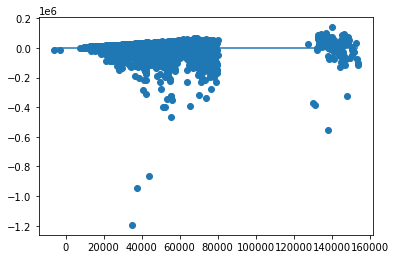

In [175]:
predictions = model.predict(X_train_scaled)
# Plot Residuals
plt.scatter(predictions, predictions - y_train)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [176]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
print(f"True output: {train_y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y_train[0]}")

x_min = X_train_scaled.min()
x_max = X_train_scaled.max()
y_min_actual = y_train.min()
y_max_actual = y_train.max()

y_min = 101.896225057 + (model.coef_ * x_min)
y_max = 101.896225057 + (model.coef_ * x_max)
print(f"Actual Min Value: {y_min_actual}")
print(f"Calculated Min Value: {y_min}")
print(f"Actual Max Value: {y_max_actual}")
print(f"Calculated Max Value: {y_max}")

# y_min_predicted = model.predict([[x_min]])
# y_max_predicted = model.predict([[x_max]])
# print(f"Actual Min Value: {y_min_actual}")
# print(f"Predicted Min Value: {y_min_predicted}")
# print(f"Actual Max Value: {y_max_actual}")
# print(f"Predicted Max Value: {y_max_predicted}")

# plt.scatter(X, y, c='blue')
# plt.plot([x_min, x_max], [y_min, y_max], c='red')

Weight coefficients:  [ 3031.28446184 -3240.1537691   5508.56183572 -4386.93585774
 -2843.1422761  14531.18508125  -654.60166078 -3976.73282796
  1604.80984265 -3659.26571614 -1244.55380163 -2493.92145486
 -2560.79119558  9814.67124578 -2607.5331494  -2120.30484688]
y-axis intercept:  47547.579174664126
True output: 17000.0
Predicted output: 55527.026635358656
Prediction Error: 38527.026635358656
Actual Min Value: 0.0
Calculated Min Value: [-12312.29200377  13371.47857086 -22457.62412338  18067.95918331
  11745.57527308 -59408.47604705   2782.72289576  16388.03184959
  -6470.37098014  15087.89109008   5198.78678379  10315.39177728
  10589.24715399 -40092.67402499  10780.67208299   8785.2988562 ]
Actual Max Value: 1230000.0
Calculated Max Value: [ 20985.90985192 -22221.1210697   38053.09542455 -30121.8684485
 -19485.9130963  100214.39674156  -4407.97745257 -27295.77747236
  11158.22269141 -25108.58997061  -8472.4487036  -17079.95862997
 -17540.65725266  67720.0068381  -17862.68562472 -1

In [177]:
reg = Lasso(max_iter=10000).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.15443675563871473
Test Score: 0.21718476540012654


C:\Users\austi\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732876561.5136719, tolerance: 1355047774.9763873
  model = cd_fast.enet_coordinate_descent(


In [178]:
reg = Ridge(alpha=100).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.154361379136857
Test Score: 0.2167348253804795


In [179]:
reg = ElasticNet(alpha=10).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.053528846531619045
Test Score: 0.07247393755826426


In [180]:
def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}')
    plt.show()
    y_pred = reg.predict(X_test_scaled)
    print(mean_absolute_error(y_test, y_pred))    
    print(mean_squared_error(y_test, y_pred)) 
    print(np.median(abs(y_test - y_pred)))
    print('\n')
    return [
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        np.median(abs(y_test - y_pred)),
        reg]


In [181]:
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [182]:
test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)
test_model(GradientBoostingRegressor(), data)
test_model(SGDRegressor(), data)
test_model(KernelRidge(), data)
test_model(BayesianRidge(), data)

Model: KNeighborsRegressor
Train score: 0.5810280331784604
Test Score: 0.31916297026880314
20715.426762589927
1785007748.7544746
9020.0


Model: RandomForestRegressor
Train score: 0.9022554805173238
Test Score: 0.5395283761161734
17883.47653203775
1207257215.4876785
8318.815000000002


Model: ExtraTreesRegressor
Train score: 0.991742015532937
Test Score: 0.5706836052277635
17647.871010791365
1125574928.905285
8036.869999999999


Model: AdaBoostRegressor
Train score: -3.5218494914767096
Test Score: -4.554206708895835
106100.94786071994
14561931241.42711
93523.33204308778


Model: SVR
Train score: -0.09016351565708192
Test Score: -0.11404139610824893
28864.99180152041
2920776100.0772696
14643.356136399378


Model: GradientBoostingRegressor
Train score: 0.5908531738404581
Test Score: 0.4632547067783588
20589.295559674203
1407230314.5532346
12114.580010201027


Model: SGDRegressor
Train score: 0.15377302503084034
Test Score: 0.21550514572165103
27454.971923143905
2056776192.5313218
19120.1

[27495.071553842616, 2053488091.8162699, 19285.10644867214, BayesianRidge()]

In [45]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3 = test_model(ExtraTreesRegressor(max_depth = i, n_estimators = j, n_jobs = -1), data)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)
    

Train score: 0.30493752994374224
Test Score: 0.1624534283172252


Train score: 0.3012049313855212
Test Score: 0.15293393471878824


Train score: 0.3073699553166577
Test Score: 0.16800644817961485


Train score: 0.30497014805116474
Test Score: 0.15807715146817725


Train score: 0.3065844117686536
Test Score: 0.16254891325860776


Train score: 0.3121078332627991
Test Score: 0.1650222406192967


Train score: 0.30885141733221355
Test Score: 0.16965749687923193


Train score: 0.30260597896021924
Test Score: 0.1582430740081172


Train score: 0.2999915529563929
Test Score: 0.1585795211102431


Train score: 0.2988956491487237
Test Score: 0.15935884554174562


Train score: 0.30447928590000906
Test Score: 0.1629726960381881


Train score: 0.30823328683043705
Test Score: 0.16593506821802806


Train score: 0.3101856156762123
Test Score: 0.16644244257753926


Train score: 0.30380912902899815
Test Score: 0.16075233539757805


Train score: 0.29663232435623677
Test Score: 0.15716610805747266


Train s

Train score: 0.3586534547072239
Test Score: 0.18956646905817098


Train score: 0.36199383649592765
Test Score: 0.19341932582833432


Train score: 0.36439988837385084
Test Score: 0.19903577878202794


Train score: 0.3648223643578943
Test Score: 0.19847905259834997


Train score: 0.3589565619774314
Test Score: 0.19122902494409844


Train score: 0.3685934517987002
Test Score: 0.1995140353051177


Train score: 0.35834844275749955
Test Score: 0.19514406482040014


Train score: 0.3637857786576316
Test Score: 0.19487728061317988


Train score: 0.36415810781877866
Test Score: 0.19578726305416316


Train score: 0.3594171902606105
Test Score: 0.19505597830336707


Train score: 0.35622295178791175
Test Score: 0.19122463596474681


Train score: 0.36270488240838383
Test Score: 0.1943797777986902


Train score: 0.3593403754588852
Test Score: 0.19573195262669807


Train score: 0.3616911267748565
Test Score: 0.19577064402931954


Train score: 0.36464925250528524
Test Score: 0.19797663476331862


Train

Train score: 0.42912040118492323
Test Score: 0.2336204101770435


Train score: 0.4279706120970578
Test Score: 0.23652287308252284


Train score: 0.427183701890797
Test Score: 0.23756348991060106


Train score: 0.4277456125090279
Test Score: 0.23515805060486072


Train score: 0.4261330586495672
Test Score: 0.2319466576370407


Train score: 0.4275117008597217
Test Score: 0.23184993890370764


Train score: 0.42418590093096853
Test Score: 0.23099145662177833


Train score: 0.4275729613537924
Test Score: 0.23958221540116942


Train score: 0.42392965510455405
Test Score: 0.22870591036296983


Train score: 0.42556442903413116
Test Score: 0.23268708784347347


Train score: 0.4285679439976914
Test Score: 0.23762316186468213


Train score: 0.42785031305072474
Test Score: 0.23324728703127395


Train score: 0.42476825256793405
Test Score: 0.2319010542749923


Train score: 0.4250737564443352
Test Score: 0.23560084421933414


Train score: 0.42920671776088215
Test Score: 0.23903024926785743


Train s

Train score: 0.496503733238264
Test Score: 0.2803368823404042


Train score: 0.501419227576636
Test Score: 0.28292957114671813


Train score: 0.4952714633680514
Test Score: 0.282658886407555


Train score: 0.4959030311944519
Test Score: 0.2792123709439518


Train score: 0.49926001755924865
Test Score: 0.2839035687653446


Train score: 0.5010722073341771
Test Score: 0.2832196225564656


Train score: 0.49949774489445475
Test Score: 0.2807655600973745


Train score: 0.4925164186775952
Test Score: 0.2784789761414933


Train score: 0.49598016284332214
Test Score: 0.28210653019792


Train score: 0.4975906050433301
Test Score: 0.28278874493923045


Train score: 0.495153228030919
Test Score: 0.2768893326726073


Train score: 0.4996837746437879
Test Score: 0.28266928205611097


Train score: 0.5004583522864242
Test Score: 0.2823856021693528


Train score: 0.500129098086413
Test Score: 0.2824264398450176


Train score: 0.4998792409108206
Test Score: 0.285337304135142


Train score: 0.498657914656

Test Score: 0.36223045246487195


Train score: 0.6330774297907704
Test Score: 0.3733935942040314


Train score: 0.6388490666416459
Test Score: 0.3724550398711932


Train score: 0.6348579007666131
Test Score: 0.35877152427919323


Train score: 0.6265317852950789
Test Score: 0.36845356413046315


Train score: 0.6410540433345213
Test Score: 0.3654209362313974


Train score: 0.637969127308667
Test Score: 0.3671693197686938


Train score: 0.6312481536394425
Test Score: 0.3515959017658178


Train score: 0.6432445838318019
Test Score: 0.3777844272116132


Train score: 0.6455991481747168
Test Score: 0.38312054903003234


Train score: 0.6418256412231523
Test Score: 0.3813711827623978


Train score: 0.6385836199450228
Test Score: 0.38026764629048226


Train score: 0.6385595111443634
Test Score: 0.37750690047938573


Train score: 0.6446368364131662
Test Score: 0.3815731183145854


Train score: 0.6388036685567533
Test Score: 0.37811653006691837


Train score: 0.6386154035561371
Test Score: 0.36941

Train score: 0.7037771796497989
Test Score: 0.41156877735804964


Train score: 0.7033740145148737
Test Score: 0.4031923276741869


Train score: 0.7044015400289864
Test Score: 0.4109434678775128


Train score: 0.7065313601429257
Test Score: 0.40862679348527087


Train score: 0.7041842836617239
Test Score: 0.4089510126226866


Train score: 0.7007942455776981
Test Score: 0.40346955419540076


Train score: 0.7037879914729788
Test Score: 0.40658215690553534


Train score: 0.7030813064349923
Test Score: 0.4131826127901611


Train score: 0.7056097191611963
Test Score: 0.40751613986129476


Train score: 0.706608734827613
Test Score: 0.4151508602349331


Train score: 0.7013642538153781
Test Score: 0.4075854050796006


Train score: 0.7029008615790837
Test Score: 0.4073408191203056


Train score: 0.7020793576168063
Test Score: 0.4048518170704487


Train score: 0.7021826276867056
Test Score: 0.4082473177780276


Train score: 0.7037960522192674
Test Score: 0.408078949560874


Train score: 0.7024394

Train score: 0.7622696435238134
Test Score: 0.43099469783712396


Train score: 0.7626748441543446
Test Score: 0.432894410067161


Train score: 0.7638104521890879
Test Score: 0.4324451343979946


Train score: 0.7642030890423155
Test Score: 0.42962665433896197


Train score: 0.7612954165381045
Test Score: 0.42671102167792163


Train score: 0.7644278115803469
Test Score: 0.43693914272574574


Train score: 0.7656557777152714
Test Score: 0.4349123306196727


Train score: 0.7664824336699217
Test Score: 0.4307896231402456


Train score: 0.762726214637959
Test Score: 0.42813517358397624


Train score: 0.7635105282567642
Test Score: 0.43475431332651926


Train score: 0.7617911396532228
Test Score: 0.4289027697382537


Train score: 0.7606421476825608
Test Score: 0.4325094551161427


Train score: 0.7657260477807697
Test Score: 0.4398264639520404


Train score: 0.7640150093055018
Test Score: 0.4337263035506327


Train score: 0.7601714521471942
Test Score: 0.4282574273540075


Train score: 0.762673



Train score: 0.8188862688963188
Test Score: 0.44863819146765505


Train score: 0.8206720251091726
Test Score: 0.45158230216608153


Train score: 0.8164344692962219
Test Score: 0.4463127049905642


Train score: 0.8174712020642785
Test Score: 0.4448004723437632


Train score: 0.8180623754167918
Test Score: 0.4449086523759591


Train score: 0.8193284713414394
Test Score: 0.44499038824793824


Train score: 0.8199143230414864
Test Score: 0.44461468546856286


Train score: 0.8173287807456429
Test Score: 0.45068956279277794


Train score: 0.8148309101406681
Test Score: 0.44736070568771935


Train score: 0.8207620495462373
Test Score: 0.4455032738814023


Train score: 0.8176898504124146
Test Score: 0.4457512365177009


Train score: 0.8193071852596471
Test Score: 0.44519996025464137


Train score: 0.8161142856427368
Test Score: 0.4408942840125877


Train score: 0.8157917786504447
Test Score: 0.44967673824784005


Train score: 0.8176664290420393
Test Score: 0.44360697192084075


Train score: 0


Train score: 0.9040139813365635
Test Score: 0.45720833792966475


Train score: 0.9037693617009187
Test Score: 0.4595596644063795


Train score: 0.8997977087627599
Test Score: 0.4503865392538976


Train score: 0.9047822057562365
Test Score: 0.4609432229219125


Train score: 0.9045230022285866
Test Score: 0.4445810598241806


Train score: 0.905802096043999
Test Score: 0.45741817757137504


Train score: 0.9045591568999011
Test Score: 0.4595543915863354


Train score: 0.899466740459927
Test Score: 0.4579197897156826


Train score: 0.9041867860070271
Test Score: 0.45833463015717113


Train score: 0.9026085881451268
Test Score: 0.4662660517467364


Train score: 0.9036401473335836
Test Score: 0.46106249659711085


Train score: 0.9027392028591364
Test Score: 0.45759421934202127


Train score: 0.9021121158507852
Test Score: 0.46205732142302536


Train score: 0.9041071656114379
Test Score: 0.45664948899477775


Train score: 0.9082409210974409
Test Score: 0.4602603047078001


Train score: 0.8994

Train score: 0.9319465864212003
Test Score: 0.460301344753382


Train score: 0.9330359831255299
Test Score: 0.4676627619033489


Train score: 0.9349506749428732
Test Score: 0.46549314892495486


Train score: 0.932618135495797
Test Score: 0.4688074535261467


Train score: 0.9316130566743639
Test Score: 0.46623874190429804


Train score: 0.9340923589242505
Test Score: 0.46454027014654153


Train score: 0.935141117804471
Test Score: 0.4599530991677796


Train score: 0.9326885082087665
Test Score: 0.4609448052045737


Train score: 0.9327036861044385
Test Score: 0.46059567121071954


Train score: 0.933756760957177
Test Score: 0.4646692053599183


Train score: 0.9341795256680335
Test Score: 0.459156405794928


Train score: 0.9331096584522417
Test Score: 0.46744291019181283


Train score: 0.9340944297445025
Test Score: 0.46508658325808405


Train score: 0.9334051379168329
Test Score: 0.45974692562525366


Train score: 0.9351617588016227
Test Score: 0.45656730295045944


Train score: 0.9330287

Train score: 0.9552970096887897
Test Score: 0.4626421233132333


Train score: 0.9554874668277562
Test Score: 0.4635010093225771


Train score: 0.9547051626843265
Test Score: 0.4640485194155838


Train score: 0.9537999622237457
Test Score: 0.4664368432581536


Train score: 0.95537278050483
Test Score: 0.4660397737242318


Train score: 0.9551077105453777
Test Score: 0.46037254474385303


Train score: 0.954793966178665
Test Score: 0.4653377940799367


Train score: 0.9547434622507649
Test Score: 0.45989783965382136


Train score: 0.9556759829383967
Test Score: 0.4621457451126635


Train score: 0.9553140903548657
Test Score: 0.46360907548165653


Train score: 0.9556161511852537
Test Score: 0.4627485262758759


Train score: 0.9542032631643516
Test Score: 0.46232983254161564


Train score: 0.9544116852165935
Test Score: 0.46924993838855855


Train score: 0.9553842136692443
Test Score: 0.46042760448330755


Train score: 0.9560759874851215
Test Score: 0.4614729973061418


Train score: 0.9540138



Train score: 0.9698062111319473
Test Score: 0.46596971573915036


Train score: 0.9694757644851134
Test Score: 0.46208322468094953


Train score: 0.969529335499926
Test Score: 0.46361280929986626


Train score: 0.9693925310518076
Test Score: 0.464009177878724


Train score: 0.9690121583314628
Test Score: 0.46698307663905947


Train score: 0.9693801818061688
Test Score: 0.4633927827072054


Train score: 0.9691129437095797
Test Score: 0.4664888567458483


Train score: 0.9696573297668034
Test Score: 0.46480727915946385


Train score: 0.9692071628527452
Test Score: 0.46435641049853105


Train score: 0.969238600939141
Test Score: 0.46189382197126383


Train score: 0.9702740505615239
Test Score: 0.4631892093214417


Train score: 0.9700374145697056
Test Score: 0.461127075149972


Train score: 0.9697316007544913
Test Score: 0.462829385429403


Train score: 0.9759925700337602
Test Score: 0.44407788059299946


Train score: 0.9789989540775612
Test Score: 0.46332680988520447


Train score: 0.9776

Train score: 0.9837701110061262
Test Score: 0.4612409653272581


Train score: 0.9840183508771009
Test Score: 0.45114799344064915


Train score: 0.9844583560301452
Test Score: 0.45553830892309344


Train score: 0.98414258192848
Test Score: 0.45171854278634227


Train score: 0.9840865226300815
Test Score: 0.4671265261018994


Train score: 0.9845426122774654
Test Score: 0.4690894565879197


Train score: 0.9844643258250683
Test Score: 0.4584052096926303


Train score: 0.9843023106328564
Test Score: 0.44849316698958097


Train score: 0.984526659144564
Test Score: 0.4570839415025686


Train score: 0.9847656935332095
Test Score: 0.46741815880663795


Train score: 0.9841656926432784
Test Score: 0.4679538507719775


Train score: 0.9844999785848729
Test Score: 0.4651486236213612


Train score: 0.9850266670862945
Test Score: 0.46060659134424653


Train score: 0.9845938456516465
Test Score: 0.4650979447269654


Train score: 0.9847848625895084
Test Score: 0.46309527205023515


Train score: 0.984693

Train score: 0.9880223898825745
Test Score: 0.4626908699257877


Train score: 0.9882319484706451
Test Score: 0.4565241088275126


Train score: 0.9882013890442264
Test Score: 0.4649716749401601


Train score: 0.9879139147418241
Test Score: 0.455161753251054


Train score: 0.9881027776166795
Test Score: 0.45891583422352433


Train score: 0.9880838496889426
Test Score: 0.46965926340555164


Train score: 0.9882432232378437
Test Score: 0.4605687189531883


Train score: 0.9882484493946848
Test Score: 0.45633858805375815


Train score: 0.9882586826012457
Test Score: 0.45628716703727


Train score: 0.9883543858603131
Test Score: 0.45655578880152703


Train score: 0.9879372476221251
Test Score: 0.4577254866608028


Train score: 0.9881356313481499
Test Score: 0.4578981258193825


Train score: 0.9880227350936311
Test Score: 0.46070936506966054


Train score: 0.9880389535128531
Test Score: 0.4572897947194965


Train score: 0.9880266698165768
Test Score: 0.4596122696078665


Train score: 0.98784267


Train score: 0.9902388038397869
Test Score: 0.46027657197314475


Train score: 0.9900636833618902
Test Score: 0.45610289693064354


Train score: 0.9900438684074682
Test Score: 0.4674413454439441


Train score: 0.9900956979163509
Test Score: 0.4509957403636623


Train score: 0.9901166310545158
Test Score: 0.4579543481820172


Train score: 0.9902163248024739
Test Score: 0.45262216804426825


Train score: 0.9901120794424941
Test Score: 0.4611879987897257


Train score: 0.9900436567001208
Test Score: 0.4570757321800959


Train score: 0.9901288211252732
Test Score: 0.4616317580781898


Train score: 0.9900933394117509
Test Score: 0.45521936342518343


Train score: 0.9902419209360387
Test Score: 0.45943337142718665


Train score: 0.9901796684147036
Test Score: 0.4550469058862261


Train score: 0.9902407273979755
Test Score: 0.45932842802107465


Train score: 0.9901625010236244
Test Score: 0.4618528828756876




KeyboardInterrupt: 

In [183]:
val1, val2, val3, model = test_model(ExtraTreesRegressor(max_depth = 21, n_estimators = 37, n_jobs = -1, random_state=12), data)
print(val1, val2, val3)

Model: ExtraTreesRegressor
Train score: 0.9891276319763368
Test Score: 0.5719547778931284
17311.425742907373
1122242188.5304298
7462.001973858354


17311.425742907373 1122242188.5304298 7462.001973858354


In [184]:
filename='Regressor_model.h5'
pickle.dump(model, open(filename, 'wb'))

In [185]:
model2 = pickle.load(open(filename, 'rb'))
model2

ExtraTreesRegressor(max_depth=21, n_estimators=37, n_jobs=-1, random_state=12)

In [46]:
print(min(mae_list))
print(min(mse_list))
print(min(median_list))

17997.142427693125
2224248799.1062913
7806.941725103141


In [47]:
print(mae_list.index(17997.142427693125))
print(mse_list.index(2224248799.1062913))
print(median_list.index(7806.941725103141))

1374
1210
1736


In [50]:
print(mae_list[1736])
print(mse_list[1736])
print(median_list[1736])

18171.449674387404
2305017895.0876565
7806.941725103141


In [106]:
#ypred

array([ 28429.53861004,  60567.5017875 , 128700.17245102, ...,
        33673.11969112,  16726.10923571, 148770.2972973 ])

In [133]:
#X_test_price = pd.DataFrame(data=ypred, index = y_test.index)
#X_train_price = pd.DataFrame(data=y_train_pred, index = y_train.index)

In [134]:
#X_test_scaled_df = pd.DataFrame(data=X_test_scaled, index = y_test.index)
#X_train_scaled_df = pd.DataFrame(data=X_train_scaled, index = y_train.index)

In [135]:
#X_test_price = pd.concat([X_test_price, X_test_scaled_df], axis=1)
#X_train_price = pd.concat([X_train_price, X_train_scaled_df], axis=1)

#X_train_price.shape

(5328, 18)

In [136]:
#Tests which parameters are best
loss_list = []
mae_list = []
loss_min = 99999999999999999999999999999999999999999999999999999999
mae_min = 99999999999999999999999999999999999999999999999999999999
for i in range(10, 101, 10):
    for j in range(10, 101, 10):
        for k in range(10, 101, 10):
                    nn = tf.keras.models.Sequential()
                    # First hidden layer
                    nn.add(tf.keras.layers.Dense(units=18, activation='selu', input_dim=17))
                    # Second hidden layer
                    nn.add(tf.keras.layers.Dense(units=k, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=j, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=i, activation='selu'))
                    # Output layer
                    nn.add(tf.keras.layers.Dense(units=1))
                    # Compile the model
                    nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

                    # Train the model
                    fit_model = nn.fit(X_train_scaled, y_train, epochs=5, verbose=0)
                    model_loss, model_mae = nn.evaluate(X_test_scaled,y_test,verbose=0)
                    loss_list.append(model_loss)
                    mae_list.append(model_mae)
                    if loss_min > min(loss_list):
                        loss_min = min(loss_list)
                        print(loss_list.index(loss_min))
                        print(f'Loss: {loss_min}')
                        print(f'{k}, {j}, {i}')
                    if mae_min > min(mae_list):
                        mae_min = min(mae_list)
                        print(mae_list.index(mae_min))
                        print(f'MAE: {mae_min}')
                        print(f'{k}, {j}, {i}')

0
Loss: 2248902400.0
10, 10, 10
0
MAE: 18234.84375
10, 10, 10
1
Loss: 2243285760.0
20, 10, 10
2
Loss: 2233491968.0
30, 10, 10
4
MAE: 18231.91015625
50, 10, 10
7
MAE: 18199.87890625
80, 10, 10
11
MAE: 18195.458984375
20, 20, 10
12
MAE: 18071.44140625
30, 20, 10
23
MAE: 18039.24609375
40, 30, 10
24
MAE: 18038.271484375
50, 30, 10


KeyboardInterrupt: 

In [59]:
#min(mae_list)

27250.837890625

In [52]:
#len(mae_list)

7388

In [53]:
#mae_list.index(27479.46484375)

433

In [54]:
#min(loss_list)

4000532480.0

In [55]:
#loss_list.index(4000532480.0)

5768

In [155]:
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(tf.keras.layers.Dense(units=18, activation='selu', input_dim=17))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=30, activation='selu'))
nn.add(tf.keras.layers.Dense(units=10, activation='selu'))
nn.add(tf.keras.layers.Dense(units=90, activation='selu'))
# Output layer
nn.add(tf.keras.layers.Dense(units=1))

In [156]:
# Compile the model
nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=10000, verbose=2)
val_acc_per_epoch = fit_model.history['mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Epoch 1/10000
167/167 - 1s - loss: 5192024576.0000 - mae: 46283.6445 - 534ms/epoch - 3ms/step
Epoch 2/10000
167/167 - 0s - loss: 5159866368.0000 - mae: 45991.2422 - 111ms/epoch - 663us/step
Epoch 3/10000
167/167 - 0s - loss: 4984809984.0000 - mae: 44370.6445 - 114ms/epoch - 681us/step
Epoch 4/10000
167/167 - 0s - loss: 4446939136.0000 - mae: 39179.2930 - 110ms/epoch - 657us/step
Epoch 5/10000
167/167 - 0s - loss: 3561054720.0000 - mae: 32060.2012 - 110ms/epoch - 657us/step
Epoch 6/10000
167/167 - 0s - loss: 3081305344.0000 - mae: 31679.2109 - 110ms/epoch - 657us/step
Epoch 7/10000
167/167 - 0s - loss: 3022867968.0000 - mae: 32064.5098 - 112ms/epoch - 669us/step
Epoch 8/10000
167/167 - 0s - loss: 2995762688.0000 - mae: 31744.5645 - 110ms/epoch - 661us/step
Epoch 9/10000
167/167 - 0s - loss: 2978128128.0000 - mae: 31766.2070 - 111ms/epoch - 663us/step
Epoch 10/10000
167/167 - 0s - loss: 2965320704.0000 - mae: 31551.0234 - 110ms/epoch - 660us/step
Epoch 11/10000
167/167 - 0s - loss: 29562

KeyboardInterrupt: 

In [157]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)

56/56 - 0s - loss: 4377388032.0000 - mae: 32799.3320 - 122ms/epoch - 2ms/step


In [158]:
y_pred = nn.predict(X_test_scaled)
y_pred

56/56 [==============================] - 0s 592us/step


array([[ 2340.8865],
       [41151.098 ],
       [37933.75  ],
       ...,
       [72315.44  ],
       [31617.916 ],
       [ 2340.8865]], dtype=float32)

In [159]:
error = y_test - y_pred[:, 0]
error

6421     25659.113525
5681      1848.902344
4678     93066.250000
4834     37983.644531
5652      6324.679688
            ...      
555      15159.113525
5095    112293.828125
3614    -47065.437500
6611    -14617.916016
1485    178666.113525
Name: final_price, Length: 1777, dtype: float64

In [160]:
np.median(abs(error))

21799.76953125

In [85]:
y_test

6421     28000.0
5681     43000.0
4678    131000.0
4834     93000.0
5652     56500.0
          ...   
555      17500.0
5095    201000.0
3614     25250.0
6611     17000.0
1485    181007.0
Name: final_price, Length: 1777, dtype: float64